# Check the GPU

In [ ]:
!nvidia-smi

Tue Jan 18 17:13:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
import os
import numpy as np

# Get TWSS data

In [ ]:
!mkdir -p data/
!wget -q https://github.com/tansaku/twss/archive/refs/heads/master.zip -O data/twss.zip
!unzip -q data/twss.zip -d data/

In [ ]:
!ls data/twss-master/data/

fml.txt		     svm_model.pk	  twssSample1.txt     usaquotes.txt.pk
fml.txt.pk	     test.pk		  twssSample2.txt     vocab.pk
README.txt	     tfln.onesent.txt	  twssstories.txt     vocab.txt
sentenceSample1.txt  tfln.onesent.txt.pk  twssstories.txt.pk
sentenceSample2.txt  train.pk		  usaquotes.txt


# Organize the files in 'pos' and 'neg' directory

In [ ]:
!mkdir -p data/pos/
!mkdir -p data/neg/
!cp data/twss-master/data/twssstories.txt data/pos/
!cp data/twss-master/data/fml.txt data/neg/
!cp data/twss-master/data/tfln.onesent.txt data/neg/
!cp data/twss-master/data/usaquotes.txt data/neg/
!ls data/pos/
!ls data/neg/

twssstories.txt
fml.txt  tfln.onesent.txt  usaquotes.txt


# Get GloVe Embeddings

In [ ]:
# Get the GloVe embeddings
!mkdir -p glove/
!wget http://nlp.stanford.edu/data/glove.6B.zip -O glove/glove.6B.zip
!unzip glove/glove.6B.zip -d glove/

--2022-01-18 17:13:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-18 17:13:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-18 17:13:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove/glove.6B.zip’

g

In [ ]:
!ls glove/

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt


In [ ]:
BASE_DIR = 'glove/'
EMBEDDING_DIM = 300
GLOVE_DIR = os.path.join(BASE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt')

embeddings_index = {}
with open(GLOVE_DIR) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# embeddings_index['apple']

# Choose a class balance:
Execute all the cells below after changing the class balance.

In [ ]:
class_balance = 'Train/Test Balanced' #@param ["Train/Test Balanced", "Only Test Balanced", "Train/Test Imbalanced"]

# Create dataset from TWSS data

In [ ]:
TWSS_DIR = 'data/'

texts = []
labels = []

# Change is_balanced to True for all preprocessing except imbalanced training data
is_balanced = False if class_balance == 'Train/Test Imbalanced' else True

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(TWSS_DIR, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='latin1')
            for i, line in enumerate(f.readlines()):
                if i >= 669 and label_type == 'neg' and is_balanced:
                    texts.append(line.rstrip())
                    labels.append(2)
                    continue
                texts.append(line.rstrip())
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)
            f.close()

In [ ]:
print("Balanced Dataset:", is_balanced)
print("Samples Count:", len(texts))
print("Labels Count", len(labels))

Balanced Dataset: True
Samples Count: 19863
Labels Count 19863


# Data Preprocessing

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100
MAX_WORDS = 15000

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

def preprocess_train_test_imbalanced(sequence_data, labels):
    data = pad_sequences(sequence_data, maxlen=MAX_LEN, padding='post')
    labels = np.asarray(labels)

    # Shuffle data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    # Train/Test split
    TEST_SPLIT = 0.9
    N = round(len(data) * TEST_SPLIT)

    train_X = data[:N]
    train_Y = labels[:N]
    test_X = data[N:]
    test_Y = labels[N:]

    return train_X, train_Y, test_X, test_Y


def preprocess_only_test_balanced(sequence_data, labels):
    all_data = pad_sequences(sequence_data, maxlen=MAX_LEN, padding='post')
    all_labels = np.asarray(labels)

    data_indices = [index for index, element in enumerate(all_labels) if element == 0 or element == 1]
    extra_data_indices = [index for index, element in enumerate(all_labels) if element == 2]

    data = all_data[np.asarray(data_indices)]
    extra_data = all_data[np.asarray(extra_data_indices)]
    print("Extra Data Length:", extra_data.shape)

    labels = all_labels[np.asarray(data_indices)]
    extra_labels = all_labels[np.asarray(extra_data_indices)]
    print("Extra Data Labels Length:", extra_labels.shape)

    # Change temp label '2' back to '0'
    extra_labels = np.where(extra_labels == 2, 0, extra_labels)

    # Shuffle data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    # Train-test split
    TRAIN_SPLIT = 0.9
    N = round(TRAIN_SPLIT * data.shape[0])

    train_X = data[:N, :]
    train_Y = labels[:N]
    test_X = data[N:, :]
    test_Y = labels[N:]

    return train_X, train_Y, test_X, test_Y


def preprocess_train_test_balanced(sequence_data, labels):
    all_data = pad_sequences(sequence_data, maxlen=MAX_LEN, padding='post')
    all_labels = np.asarray(labels)

    data_indices = [index for index, element in enumerate(all_labels) if element == 0 or element == 1]

    data = all_data[np.asarray(data_indices)]
    labels = all_labels[np.asarray(data_indices)]

    # Shuffle data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    # Train-test split
    TEST_SPLIT = 0.9
    N = round(len(data) * TEST_SPLIT)

    train_X = data[:N]
    train_Y = labels[:N]
    test_X = data[N:]
    test_Y = labels[N:]

    return train_X, train_Y, test_X, test_Y

In [ ]:
if class_balance == 'Train/Test Imbalanced':
    train_X, train_Y, test_X, test_Y = preprocess_train_test_imbalanced(sequences, labels)

elif class_balance == 'Only Test Balanced':
    train_X, train_Y, test_X, test_Y = preprocess_only_test_balanced(sequences, labels)

elif class_balance == 'Train/Test Balanced':
    train_X, train_Y, test_X, test_Y = preprocess_train_test_balanced(sequences, labels)

In [ ]:
# Verify the shape of the data
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(3631, 100)
(3631,)
(403, 100)
(403,)


In [ ]:
# Train/Test samples count
print("Neg training samples count:", np.count_nonzero(train_Y==0))
print("Pos training samples count:", np.count_nonzero(train_Y==1))

print("Neg test samples count:", np.count_nonzero(test_Y==0))
print("Pos test samples count:", np.count_nonzero(test_Y==1))

print("Number of tokens: ", len(word_index))

Neg training samples count: 1811
Pos training samples count: 1820
Neg test samples count: 196
Pos test samples count: 207
Number of tokens:  20758


# Encode TWSS words into embedding vectors

In [ ]:
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
  if i < MAX_WORDS:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(15000, 300)

# Define helper functions

In [ ]:
def print_results(results, name):
  print(f"\n{name} Results")
  print('-' * (len(name) + 1 + len("Results")))
  print(f"Loss: {results[0]:.2f}")
  print(f"Precision: {results[1]:.2%}")
  print(f"Recall: {results[2]:.2%}")
  print(f"AUC: {results[3]:.2%}")
  print(f"Accuracy: {results[4]:.2%}")

# Train the model

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10
PRETRAINED_GLOVE = True
MASKING = True
RNN_TYPE = 'GRU'
NEURAL_UNITS = 128
DROPOUT = 0.2
OPTIMIZER = 'Adam'
LEARNING_RATE = 0.001

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Masking
from tensorflow.keras.optimizers import Adam

model = Sequential()

if RNN_TYPE == 'None':
  model.add(Embedding(MAX_WORDS, 50, mask_zero=MASKING, input_length=MAX_LEN))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
else:
  model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, mask_zero=MASKING))
  model.add(GRU(NEURAL_UNITS, dropout=DROPOUT))
#   model.add(Bidirectional(GRU(NEURAL_UNITS, dropout=DROPOUT)))
  model.add(Dense(1, activation='sigmoid'))

if PRETRAINED_GLOVE:
  model.layers[0].set_weights([embedding_matrix])
  model.layers[0].trainable = False

model.summary()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=[Precision(), Recall(), AUC(), BinaryAccuracy()])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)

# For imbalanced training data but balanced test and validation data
# history = model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_data=(val_X, val_Y))

# Validation split
# history = model.fit(train_X, train_Y, epochs=100, batch_size=32,  callbacks=[es], validation_split=0.1)
# history = model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_split=0.1)

# No validation split
# history = model.fit(train_X, train_Y, epochs=100, batch_size=32,  callbacks=[es])
history = model.fit(train_X, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE)

# print(model.predict(data[:10,:]))
# print(labels[:10])
results = model.evaluate(test_X, test_Y)
print_results(results, "Test")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4500000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 4,830,497
Trainable params: 330,497
Non-trainable params: 4,500,000
_________________________________________________________________
Epoch 1/10
114/114 [==============================] - 11s 16ms/step - loss: 0.2810 - precision: 0.8638 - recall: 0.8956 - auc: 0.9531 - binary_accuracy: 0.8769
Epoch 2/10
114/114 [==============================] - 2s 16ms/step - loss: 0.1

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'precision', 'recall', 'auc', 'binary_accuracy'])


# Visualize test evaluation

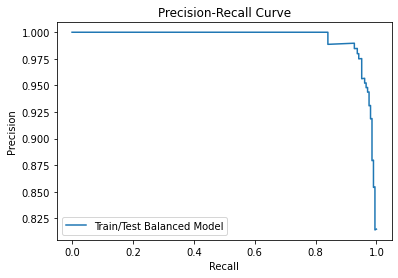

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

preds_Y = model.predict(test_X)

precision, recall, thresholds = precision_recall_curve(test_Y, preds_Y)

plt.plot(recall, precision, label=f'{class_balance} Model')
plt.title(f'Precision-Recall Curve')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# plt.savefig("best_model_pr-rc.png", dpi=256, format='png')
# show the plot
plt.show()

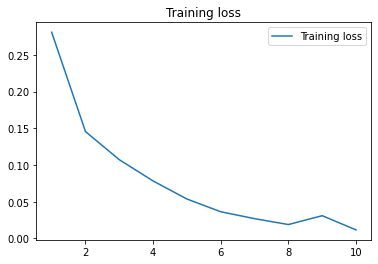

In [ ]:
import matplotlib.pyplot as plt

hist_keys = list(history.history.keys())

def plot_acc_loss(history):
    history_dict = history.history

    loss = history_dict['loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, '-', label='Training loss')
    plt.title('Training loss')
    plt.legend()

    # plt.savefig("best_model_loss.png", dpi=144, format='png')
    plt.show()

plot_acc_loss(history)

# Qualitative Evaluation

In [ ]:
from collections import OrderedDict

sample_twss = OrderedDict({
    "Wow! I cannot believe it. This is much bigger than I thought it would be.": 1,
    "He’s under a lot of pressure, which builds up until he’s ready to explode. It’s my job to release that pressure.": 1,
    "Please don't make it harder than it has to be.": 1,
    "I was trying all night yesterday, but I couldn't get it in.": 1,
    "I fear the people will not quietly submit to those restraints which are necessary for the peace and security of the community.": 0,
    "I am going to go home tonight and find a place to put this.": 1,
    "I will be completely honest with you, I wanted this so bad I could taste it.": 1,
    "Thank You! This is a true honour and I'm glad that I came.": 1,
    "I love eating apples, bananas and mango.": 0,
    "I love eating bananas.": 1,
    "I like banana trees.": 0,
    "I love reading books.": 0,
    "I spilled water all over the floor.": 0,
    "You really think you can go all day long.": 1,
    "Well, you always left me satisfied and smiling.": 1,
    "Well, you always left me angry.": 0,
    "Why did you get it so big?": 1,
    "Why did you get it so late?": 0,
    "Does the skin look red and swollen?": 1,
    "That thing looks red and swollen": 1,
    "That thing looks long, red and swollen.": 1,
    "You already did me!": 1,
    "I can't stay on top of you 24/7.": 1,
    "You don't need to be banging that hard.": 1,
    "You don't need to bang that hard.": 1,
    "Don't bang on the door that hard.": 0,
    "Long, hard and fast.": 1,
    "Can you grab my banana for a while?": 1,
    "Don’t you think these buns are a little too big for this meat?": 1,
    "No matter what you have heard, size matters.": 1,
    "No matter what you have heard, grade matters.": 0,
    "Can I play with your joystick?": 1,
    "Do you want to grab lunch?": 0,
})

sequences = tokenizer.texts_to_sequences(list(sample_twss.keys()))
twss_data = pad_sequences(sequences, maxlen=MAX_LEN)

sample_results = model.evaluate(twss_data, np.array(list(sample_twss.values())))
print_results(sample_results, "Sample Test")

predictions = model.predict(twss_data)

for i, sample in enumerate(sample_twss):
  print(f'\n{sample} => {predictions[i][0]*100:.2f}%')

2/2 [==============================] - 0s 59ms/step - loss: 1.1836 - precision: 0.7692 - recall: 0.8696 - auc: 0.7174 - binary_accuracy: 0.7273

Sample Test Results
-------------------
Loss: 1.18
Precision: 76.92%
Recall: 86.96%
AUC: 71.74%
Accuracy: 72.73%

Wow! I cannot believe it. This is much bigger than I thought it would be. => 100.00%

He’s under a lot of pressure, which builds up until he’s ready to explode. It’s my job to release that pressure. => 98.79%

Please don't make it harder than it has to be. => 99.84%

I was trying all night yesterday, but I couldn't get it in. => 28.94%

I fear the people will not quietly submit to those restraints which are necessary for the peace and security of the community. => 0.00%

I am going to go home tonight and find a place to put this. => 67.63%

I will be completely honest with you, I wanted this so bad I could taste it. => 80.23%

Thank You! This is a true honour and I'm glad that I came. => 77.87%

I love eating apples, bananas and ma